<a href="https://colab.research.google.com/github/thalitadru/ml-class-epf/blob/main/ExerciseKerasMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solution to MNIST exercise

From A. Géron's notebooks for his "Hands-on ML" book.

In [ ]:
# import the necessary libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option("display.width", 500)
pd.set_option("display.max_columns", 100)
pd.set_option("display.notebook_repr_html", True)
import seaborn as sns
import os

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
tf.__version__

'2.4.1'

In [ ]:
keras.__version__

'2.4.0'

Let's load the dataset:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 3s 0us/step


Just like for the Fashion MNIST dataset, the MNIST training set contains 60,000 grayscale images, each 28x28 pixels:

In [ ]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is also represented as a byte (0 to 255):

In [ ]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255, just like we did for Fashion MNIST:

In [ ]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Let's plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

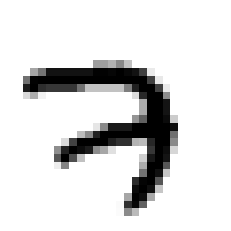

In [ ]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9. Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a `class_names` array:

In [ ]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [ ]:
X_valid.shape

(5000, 28, 28)

In [ ]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

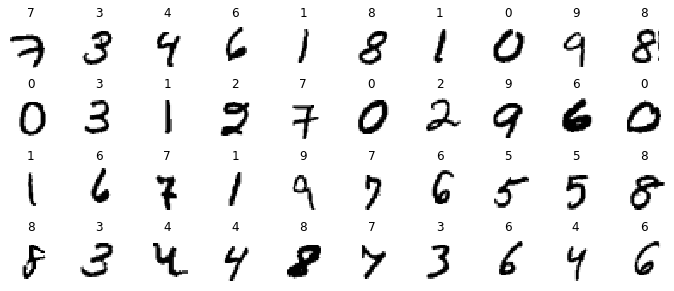

In [ ]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

2021-10-20 14:04:41.606426: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
model.save_weights('init.h5')

## Learning rate search with custom callback

In [ ]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Now let's train the model for just 1 epoch:

In [ ]:
model.load_weights('init.h5')
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

2021-10-20 14:04:42.843062: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-20 14:04:42.868923: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1800005000 Hz


1719/1719 [==============================] - 6s 3ms/step - loss: nan - accuracy: 0.4866 - val_loss: nan - val_accuracy: 0.0958


We can now plot the loss as a functionof the learning rate:

Text(0, 0.5, 'Loss')

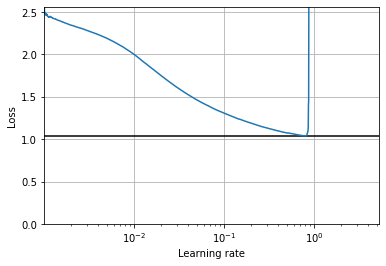

In [ ]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates), color='k')
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss starts shooting back up violently when the learning rate goes over 6e-1, so let's try using half of that, at 3e-1:

## Training the model with the chosen learning rate

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'./my_mnist_logs/run_001'

In [ ]:
model.optimizer.learning_rate=3e-1

In [ ]:
model.load_weights('init.h5')

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

2021-10-20 14:04:49.796983: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-10-20 14:04:49.797069: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-10-20 14:04:49.800660: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/100
   3/1719 [..............................] - ETA: 2:33 - loss: 2.4375 - accuracy: 0.1441

2021-10-20 14:04:50.343175: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-10-20 14:04:50.343244: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-10-20 14:04:50.355956: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-10-20 14:04:50.382588: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-10-20 14:04:50.431141: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_mnist_logs/run_001/train/plugins/profile/2021_10_20_14_04_50
2021-10-20 14:04:50.441122: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./my_mnist_logs/run_001/train/plugins/profile/2021_10_20_14_04_50/latitude-win.trace.json.gz
2021-10-20 14:04:50.472302: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_mnist_logs/run_001/train/plugins/pr

1719/1719 [==============================] - 6s 3ms/step - loss: 0.4196 - accuracy: 0.8677 - val_loss: 0.1028 - val_accuracy: 0.9696
Epoch 2/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0933 - accuracy: 0.9708 - val_loss: 0.0952 - val_accuracy: 0.9724
Epoch 3/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0677 - accuracy: 0.9781 - val_loss: 0.0906 - val_accuracy: 0.9722
Epoch 4/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0452 - accuracy: 0.9853 - val_loss: 0.0774 - val_accuracy: 0.9790
Epoch 5/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0369 - accuracy: 0.9870 - val_loss: 0.1081 - val_accuracy: 0.9698
Epoch 6/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0298 - accuracy: 0.9911 - val_loss: 0.0816 - val_accuracy: 0.9782
Epoch 7/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0232 - accuracy: 0.9924 - val_loss: 0.0784 - val_accuracy: 0.98

In [ ]:
model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0883 - accuracy: 0.9756


[0.08828520029783249, 0.975600004196167]

We got over 98% accuracy. Finally, let's look at the learning curves using TensorBoard:

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=./my_mnist_logs --port=6006

UsageError: Line magic function `%tensorboard` not found.
